In [ ]:
# Data Wrangling
import pandas as pd
import numpy as np

# Vizualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.regressor import residuals_plot, prediction_error

# Pipeline para tratar dados futuros
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Seleção e validação de modelos
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

# Pré processamento para incluir no pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler


# modelos
from sklearn.dummy import DummyRegressor # Esse Dummy é o modelo mais simples, a ideia é que os demais passem as metricas apontadas por ele
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

#Manter saída do processamento do sklearn como DataFrame pandas
from sklearn import set_config
set_config(transform_output="pandas")


import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def get_metrics(y_true, y_pred):
  # Função que retorna as metricas de avaliação para esse modelo
  dict_metrics = {
      'R2': metrics.r2_score(y_true, y_pred),
      'MAE': metrics.mean_absolute_error(y_true, y_pred),
      'MAPE': metrics.mean_absolute_percentage_error(y_true, y_pred),
      'RMSE': np.sqrt(metrics.mean_squared_error(y_true, y_pred))
  }
  return dict_metrics

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deploy/Pipelines/data/insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [ ]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


<Axes: xlabel='age', ylabel='charges'>

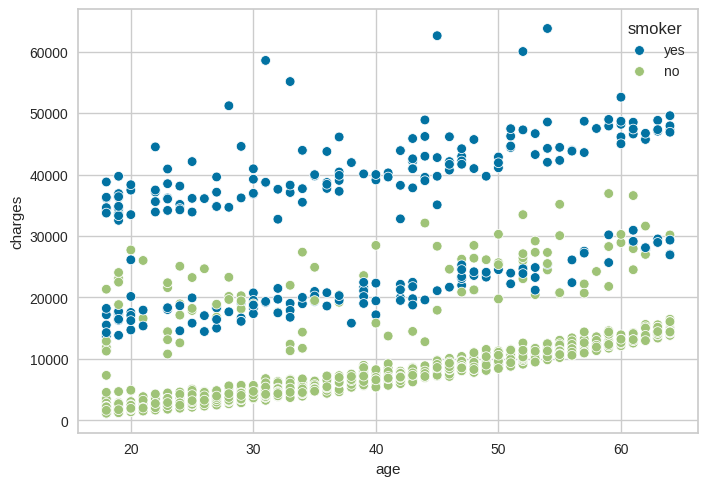

In [ ]:
sns.scatterplot(x='age', y='charges', data=df, hue='smoker')

Já podemos ver que ser fumante aumenta considerávelmente o custo de vista

<Axes: xlabel='bmi', ylabel='charges'>

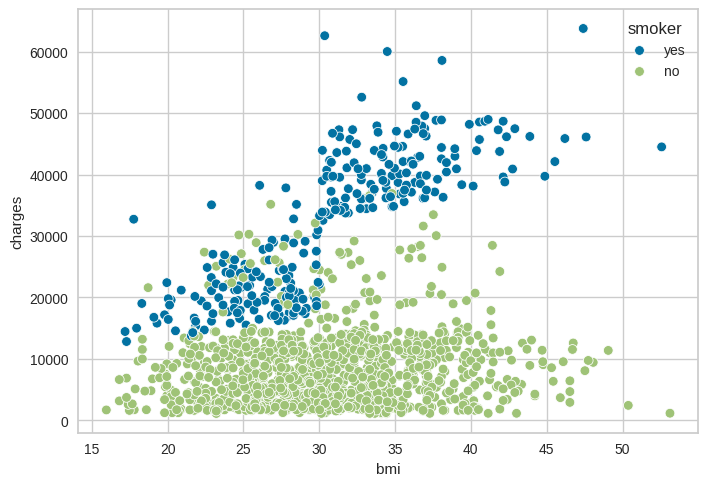

In [ ]:
sns.scatterplot(x='bmi', y='charges', data=df, hue='smoker')

novamente o status de fumante está aumentando os valores de massa corporal e o custo consequentemente

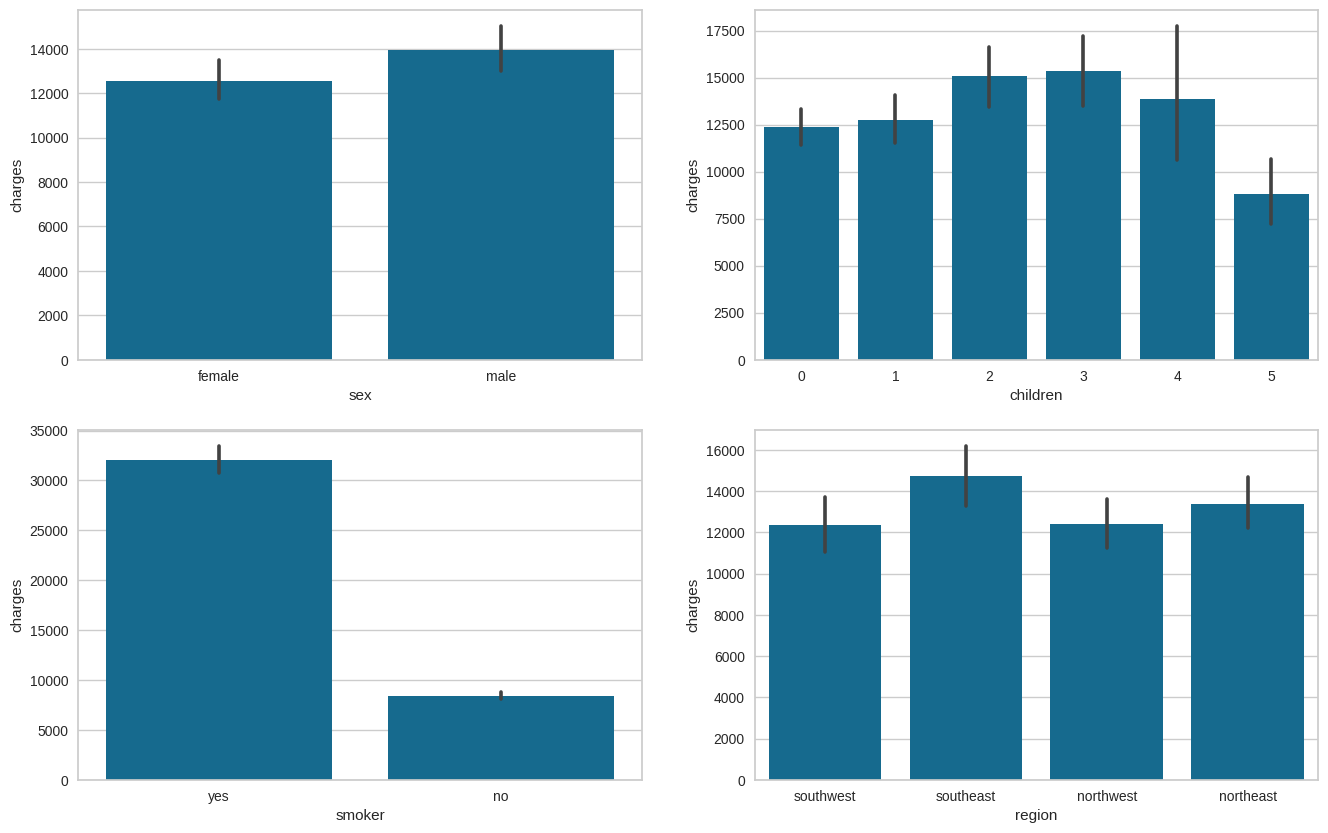

In [ ]:
cat_plot_cols = ['sex', 'children', 'smoker', 'region']

f,axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
for col, ax in zip(cat_plot_cols, axes.flatten()):
  sns.barplot(x=col, y='charges', data=df, ax=ax)

<ipython-input-24-6ba1ddcd0d0b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dfc = df.corr()


<Axes: >

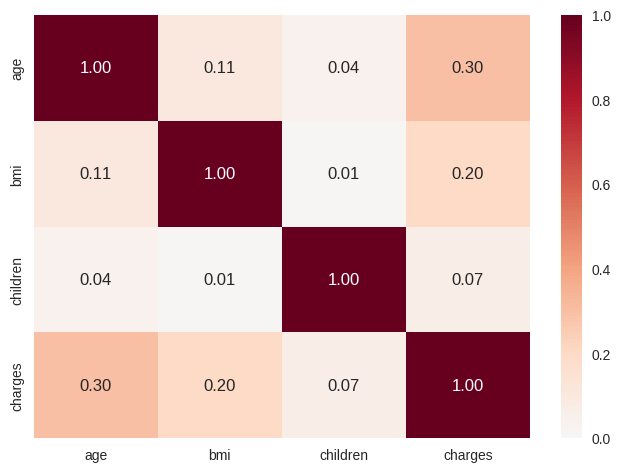

In [ ]:
dfc = df.corr()

sns.heatmap(dfc, annot=True, fmt='.2f', center= 0, vmax =1, vmin=0, cmap='RdBu_r')

<Axes: >

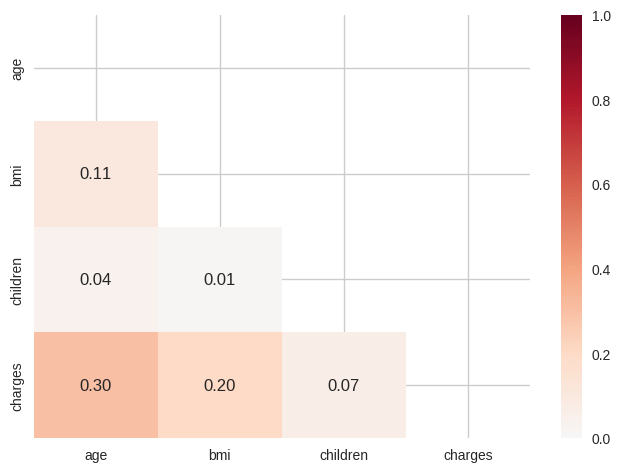

In [ ]:
# Montando para não mostrar a linha na transversal
mask = np.zeros(dfc.shape).astype(bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(dfc, annot=True, fmt='.2f', center= 0, vmax =1, vmin=0, cmap='RdBu_r', mask= mask)


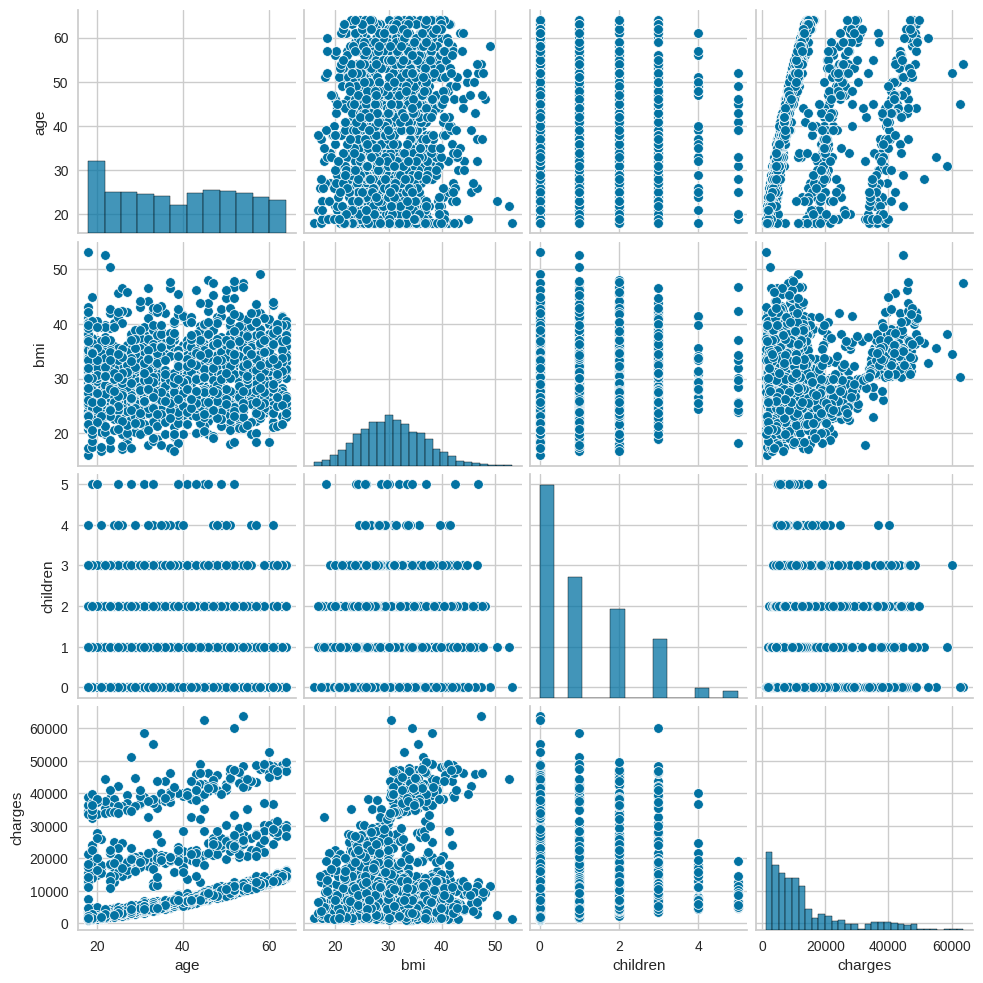

In [ ]:
sns.pairplot(df)

# Modeling

In [ ]:
# Separando as nossas features

numerical_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

features = numerical_features + categorical_features
target = 'charges'

In [ ]:
# Separando as bases de treino e teste
x = df[features]
y = df[target]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=2024)

In [ ]:
# Criando o Pipeline
# Imputer com a media para caso exista valores faltantes


numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])


preprocessor.fit_transform(x_train)

,num__age,num__bmi,num__children,cat__sex_male,cat__smoker_yes,cat__region_northeast,cat__region_northwest,cat__region_southeast,cat__region_southwest
899,0.021739,0.176352,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1129,0.021739,0.071025,0.0,0.0,0.0,0.0,0.0,0.0,1.0
916,0.543478,0.293920,0.0,0.0,1.0,0.0,1.0,0.0,0.0
526,0.021739,0.393597,0.4,0.0,0.0,0.0,1.0,0.0,0.0
850,0.413043,0.398709,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
183,0.565217,0.281141,0.0,0.0,0.0,0.0,1.0,0.0,0.0
446,0.913043,0.368039,0.0,1.0,0.0,1.0,0.0,0.0,0.0
539,0.760870,0.414044,0.0,1.0,0.0,0.0,0.0,1.0,0.0
640,0.326087,0.711326,1.0,1.0,0.0,0.0,0.0,0.0,1.0


## DummyRegressor

In [ ]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DummyRegressor())
])

model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('model', DummyRegressor())])

In [ ]:
model_pipeline.named_steps
# Com isso podemos pegar somente o modelo ou somente o preprocessor

{'preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('imputer', SimpleImputer()),
                                                  ('scaler', MinMaxScaler())]),
                                  ['age', 'bmi', 'children']),
                                 ('cat',
                                  OneHotEncoder(drop='if_binary',
                                                handle_unknown='ignore',
                                                sparse_output=False),
                                  ['sex', 'smoker', 'region'])]),
 'model': DummyRegressor()}

### GridSearch

In [ ]:
params = {
    'model':[
        DummyRegressor(),
        LinearRegression(),
        LassoCV(),
        RidgeCV(),
        RandomForestRegressor(random_state=2024),
        GradientBoostingRegressor(random_state=2024)
    ]
}


grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='r2', verbose=1)
grid_model.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('model', DummyRegressor())]),
             param_grid={'model': [DummyRegressor(), LinearRegression(),
                                   LassoCV(), RidgeCV(),
                                   RandomForestRegressor(random_state=2024),
                                   GradientBoostingRegressor(random_state=2024)]},
             scoring='r2', verbose=1)

In [ ]:
# Adquirindo a melhor metrica
grid_model.best_estimator_
# Nesse caso foi o gradient boost

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('model', GradientBoostingRegressor(random_state=2024))])

In [ ]:
df_cv_results = pd.DataFrame(grid_model.cv_results_).set_index('rank_test_score').sort_index()
df_cv_results
# Todos as metricas adquiridas

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,
1,0.133757,0.005416,0.012038,0.001379,GradientBoostingRegressor(random_state=2024),{'model': GradientBoostingRegressor(random_sta...,0.828370,0.831816,0.849967,0.856705,0.904867,0.854345,0.027421
2,0.338760,0.008725,0.021438,0.005543,RandomForestRegressor(random_state=2024),{'model': RandomForestRegressor(random_state=2...,0.825219,0.819015,0.827279,0.847800,0.899430,0.843749,0.029473
3,0.021154,0.004166,0.011665,0.002303,RidgeCV(),{'model': RidgeCV()},0.734119,0.737398,0.757967,0.742417,0.798979,0.754176,0.023849
4,0.075426,0.005647,0.010857,0.000701,LassoCV(),{'model': LassoCV()},0.734371,0.737090,0.758109,0.742644,0.798509,0.754144,0.023656
5,0.024777,0.010252,0.010421,0.000661,LinearRegression(),{'model': LinearRegression()},0.733998,0.737418,0.758181,0.741801,0.799265,0.754132,0.024042
6,0.090435,0.041430,0.033316,0.015226,DummyRegressor(),{'model': DummyRegressor()},-0.013505,-0.000873,-0.000170,-0.002953,-0.011072,-0.005714,0.005499


In [ ]:
df_cv_results.loc[:,~df_cv_results.columns.str.contains('split|time')]

,param_model,params,mean_test_score,std_test_score
rank_test_score,,,,
1,GradientBoostingRegressor(random_state=2024),{'model': GradientBoostingRegressor(random_sta...,0.854345,0.027421
2,RandomForestRegressor(random_state=2024),{'model': RandomForestRegressor(random_state=2...,0.843749,0.029473
3,RidgeCV(),{'model': RidgeCV()},0.754176,0.023849
4,LassoCV(),{'model': LassoCV()},0.754144,0.023656
5,LinearRegression(),{'model': LinearRegression()},0.754132,0.024042
6,DummyRegressor(),{'model': DummyRegressor()},-0.005714,0.005499


Ao final foi visto que o Gradient boost performou muito bem e obteve metricas boas e que satisfazem o nosso problema

## Tunning GradientBoost

In [ ]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=2024))
])

params = {
    'model__learning_rate': [0.1, 0.01],
    'model__max_depth': [3, 4, 5],
    'model__n_estimators': [300, 400, 500],
    'model__subsample': [1.0, 0.8]
}



grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='r2',n_jobs=-1, verbose=1)
grid_model.fit(x_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('model',
                                        GradientBoostingRegressor(random_state=2024))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.1, 0.01],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [300, 400, 500],
                         'model__subsample': [1.0, 0.8]},
             scoring='r2', verbose=1)

In [ ]:
df_cv_results = pd.DataFrame(grid_model.cv_results_).set_index('rank_test_score').sort_index()
df_cv_results.loc[:,~df_cv_results.columns.str.contains('split|time')]

,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,mean_test_score,std_test_score
rank_test_score,,,,,,,
1,0.01,3,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.863196,0.025170
2,0.01,3,500,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.863013,0.025473
3,0.01,3,400,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.863000,0.024729
4,0.01,3,500,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.862543,0.025251
5,0.01,3,300,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.861234,0.024962
6,0.01,3,300,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.860261,0.024791
7,0.01,4,400,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.859127,0.026087
8,0.01,4,300,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.858952,0.025217
9,0.01,4,300,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.858872,0.026001


Montando o Pipeline do melhor Modelo

In [ ]:
model_pipeline = grid_model.best_estimator_

In [ ]:
y_pred =  model_pipeline.predict(x_test)

# Verificando as metricas
get_metrics(y_test, y_pred)

{'R2': 0.8403934940710257,
 'MAE': 2692.2380288855784,
 'MAPE': 0.33007405067595325,
 'RMSE': 4885.335940599407}

Verificando residuos

<Axes: xlabel='charges'>

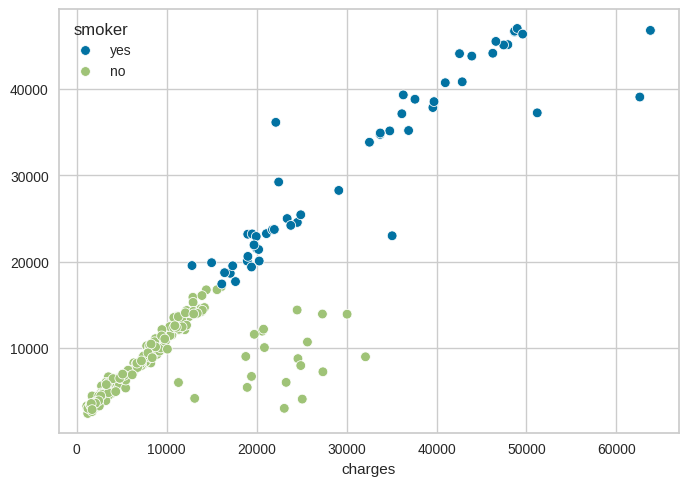

In [ ]:
sns.scatterplot(x=y_test, y=y_pred, hue=x_test.smoker)

<Axes: >

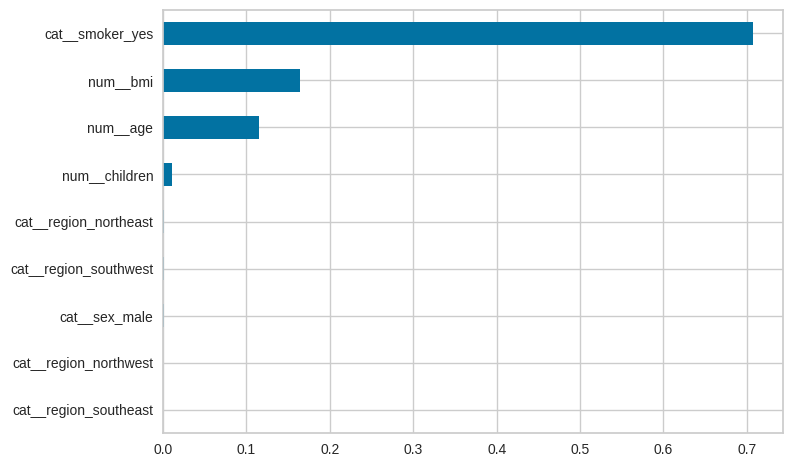

In [ ]:
# Quais foram as features mais importantes
importances = pd.Series(
    data= model_pipeline.named_steps['model'].feature_importances_,
    index=model_pipeline.named_steps['preprocessor'].get_feature_names_out()
)

importances.sort_values().plot.barh()

# model_pipeline.named_steps['model'].feature_importances_
# model_pipeline.named_steps['preprocessor'].get_feature_names_out()

De longe podemos ver que ser fumante decidiu e muito o modelo, seguindo com uma importancia enorme

In [ ]:
# Fechando o Pipeline sabendo de quais são as features mais importantes

numerical_features =['age', 'bmi', 'children']
categorical_features = ['smoker']

features = numerical_features + categorical_features

target = 'charges'

x = df[features]
y = df[target]


x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=2024)

In [ ]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])


categorical_transformer = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=2024))
])


params = {
    'model__learning_rate': [0.1, 0.01],
    'model__max_depth': [3, 4, 5],
    'model__n_estimators': [300, 400, 500],
    'model__subsample': [1.0, 0.8]
}



grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='r2',n_jobs=-1, verbose=1)
grid_model.fit(x_train, y_train)


df_cv_results = pd.DataFrame(grid_model.cv_results_).set_index('rank_test_score').sort_index()
df_cv_results.loc[:,~df_cv_results.columns.str.contains('split|time')]

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,mean_test_score,std_test_score
rank_test_score,,,,,,,
1,0.01,3,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.862723,0.024814
2,0.01,3,400,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.862669,0.024842
3,0.01,3,500,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.862112,0.025047
4,0.01,3,500,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.861443,0.025185
5,0.01,3,300,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.861168,0.024871
6,0.01,3,300,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.860236,0.024953
7,0.01,4,400,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.858638,0.025196
8,0.01,4,300,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.858419,0.025240
9,0.01,4,300,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.858192,0.026225


In [ ]:
model_pipeline = grid_model.best_estimator_
y_pred = model_pipeline.predict(x_test)

get_metrics(y_test, y_pred)

{'R2': 0.8399200337161572,
 'MAE': 2681.7268283362355,
 'MAPE': 0.3368843226082203,
 'RMSE': 4892.57656049359}

<Axes: >

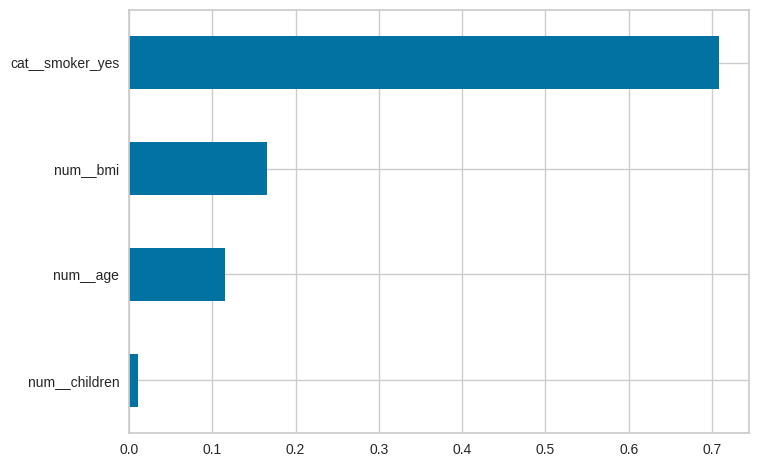

In [ ]:
# Quais foram as features mais importantes
importances = pd.Series(
    data= model_pipeline.named_steps['model'].feature_importances_,
    index=model_pipeline.named_steps['preprocessor'].get_feature_names_out()
)

importances.sort_values().plot.barh()

## Montando para ser exportado

In [ ]:
with open('models/model.pkl', 'wb') as file_model:
  pickle.dump(model_pipeline, file_model)